## Baseline

This notebook explores important features with Decision Tree and uses LogReg as a baseline model

In [19]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, precision_score
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression


# Manual Train test split -- splits session ID in .70 of the session for train and .3 of the session for test.
#Returns a train dataframe and a test
from src.train_test_split_df import *

In [2]:
df = pd.read_csv('data/tracks_session_clean.csv', index_col=0)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167880 entries, 0 to 167879
Data columns (total 48 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   session_id                       167880 non-null  object 
 1   session_position                 167880 non-null  int64  
 2   session_length                   167880 non-null  int64  
 3   date                             167880 non-null  object 
 4   EarlyAM                          167880 non-null  int64  
 5   Evening                          167880 non-null  int64  
 6   LateAMEarlyPM                    167880 non-null  int64  
 7   LatePM                           167880 non-null  int64  
 8   Night                            167880 non-null  int64  
 9   track_id                         167880 non-null  object 
 10  skipped                          167880 non-null  int64  
 11  hist_seekfwd                     167880 non-null  int64  
 12  hi

In [4]:
drop_col = ['session_id', 'session_length', 'date', 'track_id', 'hist_user_behavior_reason_start', 'beat_strength', 'dyn_range_mean']
def drop(df):
    df = df.drop(labels=drop_col, axis=1)
    return df

### Decision Tree

In [5]:
Train, test = train_test_split_df(df)

In [6]:
Train = drop(Train)
Test = drop(test)

In [7]:
X_train = Train.drop('skipped', axis=1)
X_test = Test.drop('skipped', axis=1)
y_train = Train['skipped']
y_test = Test['skipped']

In [8]:
dt = DecisionTreeClassifier()

In [9]:
param_grid = {'max_depth': range(2, 11),
             'min_samples_split': range(2,5)
             }
gs = GridSearchCV(dt, param_grid)
gs.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': range(2, 11),
                         'min_samples_split': range(2, 5)})

In [11]:
gs.best_params_

{'max_depth': 8, 'min_samples_split': 2}

In [12]:
dt = DecisionTreeClassifier(max_depth=8)

In [14]:
dt.fit(X_train, y_train)
dt.score(X_test, y_test)

0.5417779473483403

In [16]:
features=X_train.columns.tolist()
important = dt.feature_importances_
important_features = pd.DataFrame(important, index=features, columns=['Important'])
important_features.sort_values('Important', ascending=False).head(15)

,Important
pause_before_play,0.272000
catalog,0.077645
session_position,0.066275
hist_seekback,0.064489
hist_shuffle,0.058512
premium,0.041026
duration,0.035954
hist_seekfwd,0.035128
radio,0.032601
acoustic_vector_0,0.031448


In [17]:
preds= dt.predict(X_test)

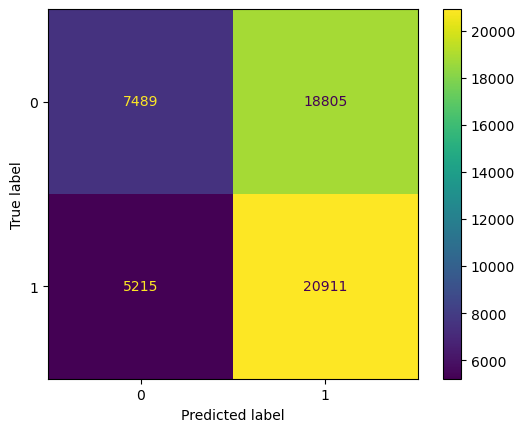

In [18]:
cm = confusion_matrix(y_test, preds)
ConfusionMatrixDisplay(cm).plot()

In [20]:
precision_score(y_test, preds)

0.5265132440326317

Important features causing skips:

- pause_before_play	
- catalog	
- hist_seekback	
- radio	
- editorial_playlist
- hist_shuffle
- hist_seekfwd
- session_position

# Logistic Regression

In [21]:
Train, test = train_test_split_df(df)

In [ ]:
Train = drop(Train)
Test = drop(test)

In [22]:
X_train = Train['pause_before_play'].array.reshape(-1, 1)
X_test = Test['pause_before_play'].array.reshape(-1, 1)
y_train = Train['skipped']
y_test = Test['skipped']

In [23]:
logreg = LogisticRegression()

In [32]:
param_grid = {'penalty': ['l2'],
             'C': [.1, 10, 100, 1000, 10000],
              'solver': ['liblinear', 'newton-cg'],
             }
gs = GridSearchCV(logreg, param_grid)

In [33]:
gs.fit(X_train, y_train)

/Users/RachaelMcCue/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/RachaelMcCue/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/Users/RachaelMcCue/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/RachaelMcCue/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/Users/RachaelMcCue/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', 

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.1, 10, 100, 1000, 10000], 'penalty': ['l2'],
                         'solver': ['liblinear', 'newton-cg']})

In [38]:
gs.best_params_

{'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}

In [40]:
logreg = LogisticRegression(penalty='l2', C=.1, solver='liblinear')

In [41]:
logreg.fit(X_train, y_train)

LogisticRegression(C=0.1, solver='liblinear')

In [42]:
logreg.score(X_test, y_test)

0.5252575352918734

In [43]:
coef = logreg.coef_

In [46]:
odds = np.exp(coef)
odds.astype(float)

array([[1.76702666]])

If there is a pause before playing, that improves the chance of skipping my 1.76 times. 

In [ ]:
coefs = pd.DataFrame(zip(X_train.columns, np.transpose(logreg.coef_)), columns=['features', 'coef'])
coefs['odds'] = [np.exp(x) for x in coefs['coef']]
coefs

In [ ]:
log_loss(y_test, logreg.predict_proba(X_test_scaled))